In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils

In [2]:
conn = utils.db_connect()

df_rounds = pd.read_sql("select * from rounds", conn)
df_events = pd.read_sql("select * from events", conn)

# convert event_id to int
df_rounds['event_id'] = df_rounds['event_id'].astype(int)
# join rounds to events
df = pd.merge(df_rounds,
               df_events[['event_id', 'calendar_year', 'tour', 'has_sg', 'has_traditional_stats']],
                 left_on= ['event_id','year', 'tour'], right_on=['event_id','calendar_year', 'tour'], how='left')

# clean some stuff up
# if has_traditional_stats is 'no', then make the columns null
df.loc[df['has_traditional_stats'] == 'no', ['driving_acc', 'driving_dist', 'gir', 'scrambling', 'prox_rgh', 'prox_fw', 'great_shots', 'poor_shots']] = np.nan
# if has_traditional_stats is not no, but driving dist + gir = 0, make them all null
df.loc[(df['has_traditional_stats'] != 'no') & (df['driving_dist'] == 0) & (df['gir'] == 0), ['driving_acc', 'driving_dist', 'gir', 'scrambling', 'prox_rgh', 'prox_fw', 'great_shots', 'poor_shots']] = np.nan
df.loc[df['has_sg'] == 'no', ['sg_putt', 'sg_arg', 'sg_app', 'sg_off_tee', 'sg_t2g', 'sg_total']] = np.nan
# convert to bool
df['has_traditional_stats'] = df['has_traditional_stats'] == 'yes'
df['has_sg'] = df['has_sg'] == 'yes'
# convert teetime in format '12:54pm' to time, if not missing
df['teetime'] =  pd.to_datetime(df['teetime'], format='%I:%M%p', errors='coerce').dt.time
df.drop(['calendar_year'], axis=1, inplace=True)

2023-07-23 18:26:08,335 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-07-23 18:26:08,336 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 18:26:08,495 INFO sqlalchemy.engine.Engine select current_schema()
2023-07-23 18:26:08,495 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 18:26:08,701 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-07-23 18:26:08,701 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 18:26:08,896 INFO sqlalchemy.engine.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2023-07-23 18:26:08,897 INFO sqlalchemy.engine.Engine [generated in 0.00064s] {'name': 'select * from rounds'}
2023-07-23 18:26:09,100 INFO sqlalchemy.engine.Engine select * from rounds
2023-07-23 18:26:09,100 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 18:26:17,644 INFO sqlalchemy.engine.Engine select relname from pg_class c join pg_namespace n 

In [3]:
df.head().T

,0,1,2,3,4
tour,pga,pga,pga,pga,pga
year,2023,2023,2023,2023,2023
season,2023,2023,2023,2023,2023
event_name,John Deere Classic,John Deere Classic,John Deere Classic,John Deere Classic,John Deere Classic
event_id,30,30,30,30,30
player_name,"Straka, Sepp","Straka, Sepp","Straka, Sepp","Straka, Sepp","Todd, Brendon"
dg_id,17511,17511,17511,17511,12425
fin_text,1,1,1,1,T2
round_num,1,2,3,4,1
course_name,TPC Deere Run,TPC Deere Run,TPC Deere Run,TPC Deere Run,TPC Deere Run


In [4]:
drop_statement = """
DROP TABLE IF EXISTS gold.rounds;
"""

create_statement = """
CREATE TABLE gold.rounds (
    tour varchar(10),
    year int,
    season int,
    event_id int,
    event_name varchar(100),
    course_name varchar(100),
    course_num int,
    course_par int,
    dg_id int,
    player_name varchar(100),
    fin_text varchar(10),
    round_num int,
    start_hole int,
    teetime time,
    round_score int,
    sg_putt float,
    sg_arg float,
    sg_app float,
    sg_off_tee float,
    sg_t2g float,
    sg_total float,
    driving_acc float,
    driving_dist float,
    gir float,
    scrambling float,
    prox_rgh float,
    prox_fw float,
    great_shots int,
    poor_shots int,
    has_traditional_stats boolean,
    has_sg boolean
);
"""

In [5]:
# create the table
conn.execute(drop_statement)
conn.execute(create_statement)

# write the dataframe to the database
utils.write_to_db(df, 'rounds', schema='gold', append=True)

conn.close()

2023-07-23 18:26:28,138 INFO sqlalchemy.engine.Engine 
DROP TABLE IF EXISTS gold.rounds;

2023-07-23 18:26:28,138 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 18:30:40,753 INFO sqlalchemy.engine.Engine COMMIT
2023-07-23 18:30:40,843 INFO sqlalchemy.engine.Engine 
CREATE TABLE gold.rounds (
    tour varchar(10),
    year int,
    season int,
    event_id int,
    event_name varchar(100),
    course_name varchar(100),
    course_num int,
    course_par int,
    dg_id int,
    player_name varchar(100),
    fin_text varchar(10),
    round_num int,
    start_hole int,
    teetime time,
    round_score int,
    sg_putt float,
    sg_arg float,
    sg_app float,
    sg_off_tee float,
    sg_t2g float,
    sg_total float,
    driving_acc float,
    driving_dist float,
    gir float,
    scrambling float,
    prox_rgh float,
    prox_fw float,
    great_shots int,
    poor_shots int,
    has_traditional_stats boolean,
    has_sg boolean
);

2023-07-23 18:30:40,844 INFO sqlalchemy.engin

array([[<AxesSubplot:title={'center':'driving_acc'}>,
        <AxesSubplot:title={'center':'driving_dist'}>],
       [<AxesSubplot:title={'center':'gir'}>,
        <AxesSubplot:title={'center':'scrambling'}>],
       [<AxesSubplot:title={'center':'round_score'}>, <AxesSubplot:>]],
      dtype=object)

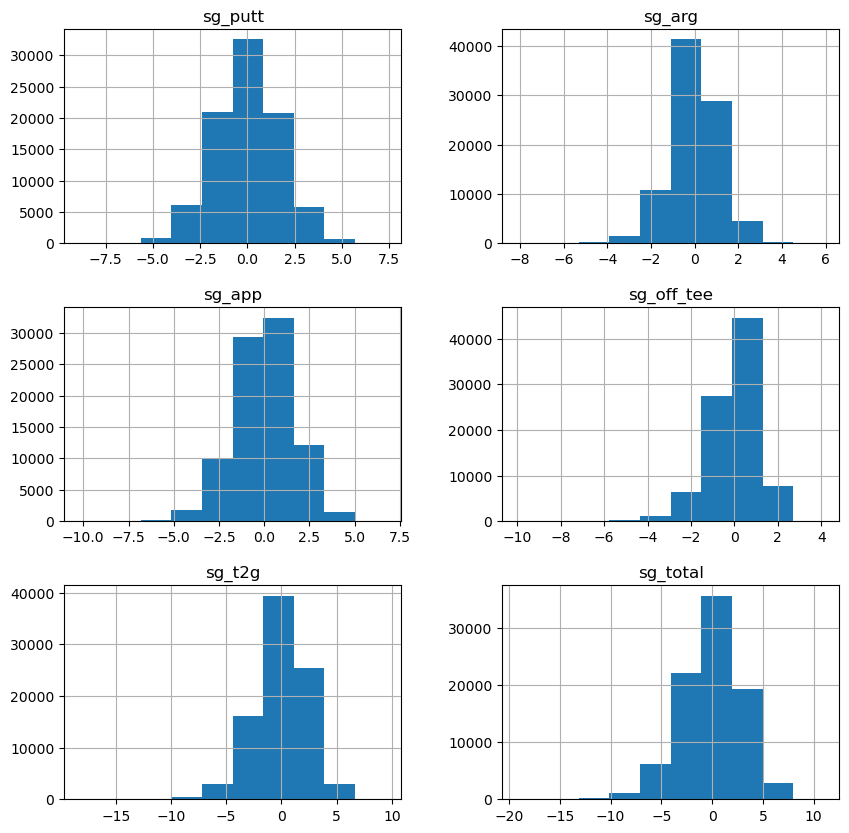

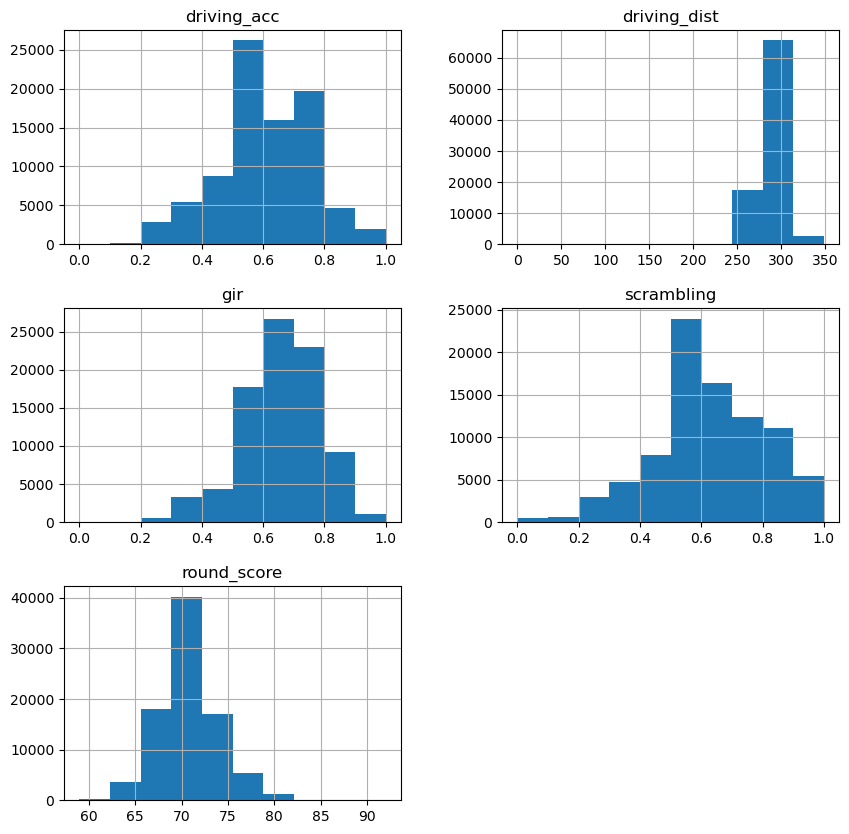

In [29]:
# find rows where has_sg is 'yes'
test_df = df[df['has_sg'] == 'yes']
test_df[['sg_putt', 'sg_arg', 'sg_app', 'sg_off_tee', 'sg_t2g', 'sg_total']].hist(figsize=(10,10))
test_df2 = df[df['has_traditional_stats'] == 'yes']
test_df2[['driving_acc', 'driving_dist', 'gir', 'scrambling', 'round_score']].hist(figsize=(10,10))

array([[<AxesSubplot:title={'center':'driving_acc'}>,
        <AxesSubplot:title={'center':'driving_dist'}>],
       [<AxesSubplot:title={'center':'gir'}>,
        <AxesSubplot:title={'center':'scrambling'}>],
       [<AxesSubplot:title={'center':'round_score'}>, <AxesSubplot:>]],
      dtype=object)

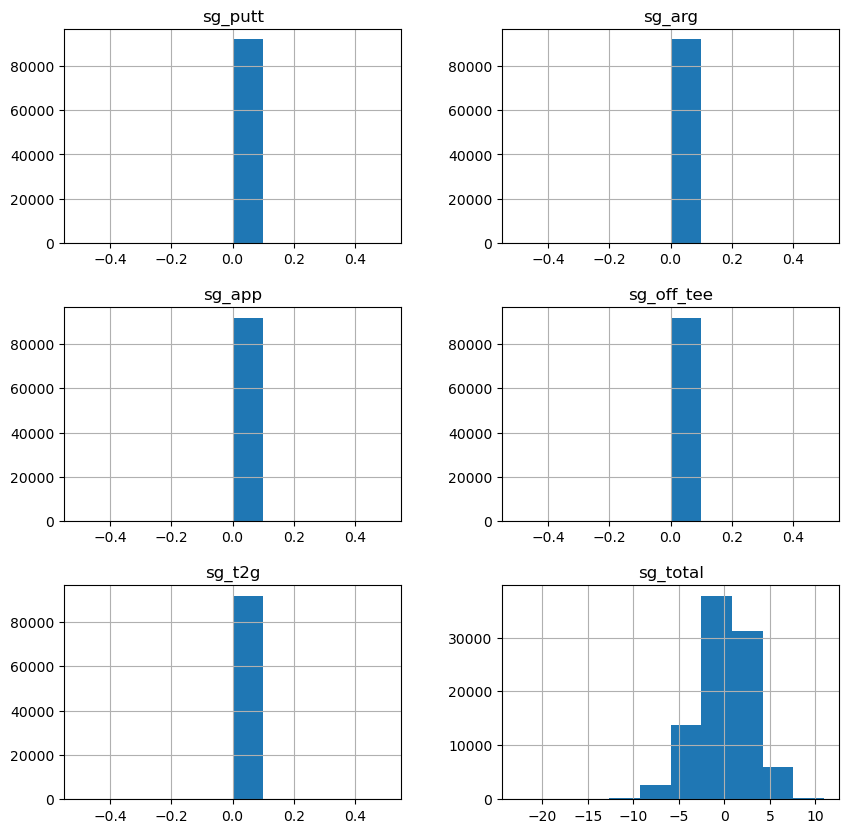

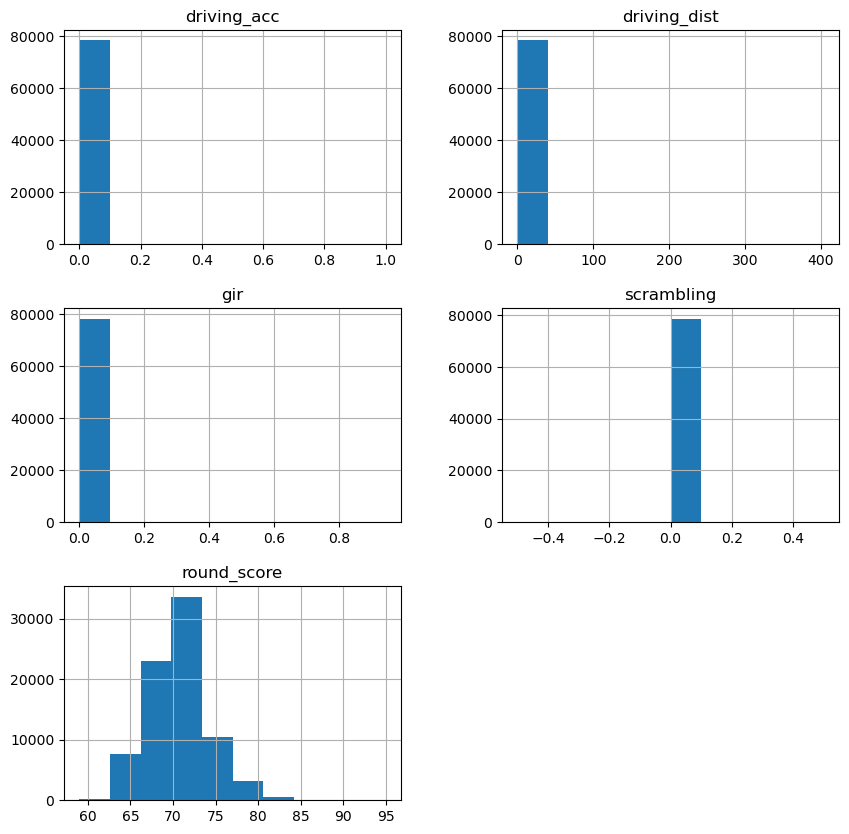

In [31]:
test_df = df[df['has_sg'] == 'no']
test_df[['sg_putt', 'sg_arg', 'sg_app', 'sg_off_tee', 'sg_t2g', 'sg_total']].hist(figsize=(10,10))
test_df2 = df[df['has_traditional_stats'] == 'no']
test_df2[['driving_acc', 'driving_dist', 'gir', 'scrambling', 'round_score']].hist(figsize=(10,10))

In [32]:
test_df2.head().T

,929,930,931,932,933
tour,kft,kft,kft,kft,kft
year,2023,2023,2023,2023,2023
season,2023,2023,2023,2023,2023
event_name,Memorial Health Championship presented by LRS,Memorial Health Championship presented by LRS,Memorial Health Championship presented by LRS,Memorial Health Championship presented by LRS,Memorial Health Championship presented by LRS
event_id,122,122,122,122,122
player_name,"Barjon, Paul","Barjon, Paul","Barjon, Paul","Barjon, Paul","Suber, Jackson"
dg_id,16566,16566,16566,16566,29279
fin_text,1,1,1,1,2
round_num,1,2,3,4,1
course_name,Panther Creek Country Club,Panther Creek Country Club,Panther Creek Country Club,Panther Creek Country Club,Panther Creek Country Club


# Events

In [2]:
conn = utils.db_connect()

# df_rounds = pd.read_sql("select * from rounds", conn)
df = pd.read_sql("select * from events", conn)

df['has_traditional_stats'] = df['has_traditional_stats'] == 'yes'
df['has_sg'] = df['has_sg'] == 'yes'
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
# season is calendar year + 1 if month > 8 and calendar_year > 2013
df['season'] = df['date'].dt.year
df.loc[(df['date'].dt.month > 8) & (df['date'].dt.year >= 2013), 'season'] = df['season'] + 1

df.head()

2023-07-23 15:45:13,952 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-07-23 15:45:13,953 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 15:45:14,106 INFO sqlalchemy.engine.Engine select current_schema()
2023-07-23 15:45:14,107 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 15:45:14,259 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-07-23 15:45:14,260 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 15:45:14,412 INFO sqlalchemy.engine.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2023-07-23 15:45:14,413 INFO sqlalchemy.engine.Engine [generated in 0.00062s] {'name': 'select * from events'}
2023-07-23 15:45:14,568 INFO sqlalchemy.engine.Engine select * from events
2023-07-23 15:45:14,569 INFO sqlalchemy.engine.Engine [raw sql] {}


,calendar_year,date,event_id,event_name,has_sg,tour,has_traditional_stats,season
0,2023,2023-07-09,30,John Deere Classic,True,pga,True,2023
1,2023,2023-07-09,17,London,False,liv,False,2023
2,2023,2023-07-09,2023130,Made in HimmerLand,False,euro,False,2023
3,2023,2023-07-09,2023312,Italian Challenge Open,False,cha,False,2023
4,2023,2023-07-09,10046,ADT - All Thailand Partnership Trophy,False,adt,False,2023


In [3]:
drop_statement = """
DROP TABLE IF EXISTS gold.events;
"""

create_statement = """
CREATE TABLE gold.events (
    event_id int,
    event_name varchar(100),
    season int,
    calendar_year int,
    date date,
    tour varchar(10),
    has_sg boolean,
    has_traditional_stats boolean
);
"""

In [4]:
# create the table
conn.execute(drop_statement)
conn.execute(create_statement)

# write the dataframe to the database
utils.write_to_db(df, 'events', schema='gold', append=True)

conn.close()

2023-07-23 15:45:33,869 INFO sqlalchemy.engine.Engine 
DROP TABLE IF EXISTS gold.events;

2023-07-23 15:45:33,869 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 15:45:33,954 INFO sqlalchemy.engine.Engine COMMIT
2023-07-23 15:45:34,034 INFO sqlalchemy.engine.Engine 
CREATE TABLE gold.events (
    event_id int,
    event_name varchar(100),
    season int,
    calendar_year int,
    date date,
    tour varchar(10),
    has_sg boolean,
    has_traditional_stats boolean
);

2023-07-23 15:45:34,035 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 15:45:34,197 INFO sqlalchemy.engine.Engine COMMIT
2023-07-23 15:45:35,096 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-07-23 15:45:35,097 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 15:45:35,251 INFO sqlalchemy.engine.Engine select current_schema()
2023-07-23 15:45:35,251 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 15:45:35,413 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-07-23

# Players

In [11]:
# conn = utils.db_connect()

df = pd.read_sql("select * from public.players", conn)

df['dg_id'] = df['dg_id'].astype(int)
df['amateur'] = df['amateur'] == 'yes'

2023-07-22 18:52:54,549 INFO sqlalchemy.engine.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2023-07-22 18:52:54,549 INFO sqlalchemy.engine.Engine [generated in 0.00087s] {'name': 'select * from public.players'}
2023-07-22 18:52:54,704 INFO sqlalchemy.engine.Engine select * from public.players
2023-07-22 18:52:54,705 INFO sqlalchemy.engine.Engine [raw sql] {}


In [20]:
drop_statement = """
DROP TABLE IF EXISTS gold.players;
"""

create_statement = """
CREATE TABLE gold.players (
    dg_id int,
    amateur boolean,
    name varchar(100),
    country varchar(100),
    country_code varchar(10)
);
"""

In [21]:
# create the table
conn.execute(drop_statement)
conn.execute(create_statement)

# write the dataframe to the database
utils.write_to_db(df, 'players', schema='gold', append=True)

conn.close()

2023-07-22 18:58:01,507 INFO sqlalchemy.engine.Engine 
DROP TABLE IF EXISTS gold.players;

2023-07-22 18:58:01,507 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 18:58:01,663 INFO sqlalchemy.engine.Engine COMMIT
2023-07-22 18:58:01,744 INFO sqlalchemy.engine.Engine 
CREATE TABLE gold.players (
    dg_id int,
    amateur boolean,
    name varchar(100),
    country varchar(100),
    country_code varchar(10)
);

2023-07-22 18:58:01,745 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 18:58:01,900 INFO sqlalchemy.engine.Engine COMMIT
2023-07-22 18:58:02,835 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-07-22 18:58:02,836 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 18:58:02,997 INFO sqlalchemy.engine.Engine select current_schema()
2023-07-22 18:58:02,998 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 18:58:03,150 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-07-22 18:58:03,151 INFO sqlalchemy.engine.Engine [raw sql] {}
2023

# rankings

In [23]:
conn = utils.db_connect()

df = pd.read_sql("select * from public.rankings", conn)

# dg_id to int
df['dg_id'] = df['dg_id'].astype(int)
# amateur to bool
df['amateur'] = df['amateur'] == 'yes'
# updated_at to datetime
df['updated_at'] = pd.to_datetime(df['updated_at'], format='%Y-%m-%d %H:%M:%S')

2023-07-22 19:06:00,436 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-07-22 19:06:00,437 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 19:06:00,591 INFO sqlalchemy.engine.Engine select current_schema()
2023-07-22 19:06:00,591 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 19:06:00,745 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-07-22 19:06:00,746 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 19:06:00,900 INFO sqlalchemy.engine.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2023-07-22 19:06:00,901 INFO sqlalchemy.engine.Engine [generated in 0.00069s] {'name': 'select * from public.rankings'}
2023-07-22 19:06:01,052 INFO sqlalchemy.engine.Engine select * from public.rankings
2023-07-22 19:06:01,052 INFO sqlalchemy.engine.Engine [raw sql] {}


In [28]:
drop_statement = """
DROP TABLE IF EXISTS gold.rankings;
"""

create_statement = """
CREATE TABLE gold.rankings (
    dg_id int,
    amateur boolean,
    player varchar(100),
    primary_tour varchar(10),
    country varchar(100),
    dg_rank int,
    dg_skill_estimate numeric,
    owgr_rank int,
    updated_at timestamp
);
"""

In [30]:
# create the table
conn.execute(drop_statement)
conn.execute(create_statement)

# write the dataframe to the database
utils.write_to_db(df, 'rankings', schema='gold', append=True)

conn.close()

2023-07-22 19:09:22,176 INFO sqlalchemy.engine.Engine 
DROP TABLE IF EXISTS gold.rankings;

2023-07-22 19:09:22,177 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 19:09:22,253 INFO sqlalchemy.engine.Engine COMMIT
2023-07-22 19:09:22,336 INFO sqlalchemy.engine.Engine 
CREATE TABLE gold.rankings (
    dg_id int,
    amateur boolean,
    player varchar(100),
    primary_tour varchar(10),
    country varchar(100),
    dg_rank int,
    dg_skill_estimate numeric,
    owgr_rank int,
    updated_at timestamp
);

2023-07-22 19:09:22,337 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 19:09:22,491 INFO sqlalchemy.engine.Engine COMMIT
2023-07-22 19:09:23,390 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-07-22 19:09:23,390 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 19:09:23,553 INFO sqlalchemy.engine.Engine select current_schema()
2023-07-22 19:09:23,555 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 19:09:23,717 INFO sqlalchemy.engine.Engine show st

# Earnings

In [5]:
conn = utils.db_connect()

df = pd.read_sql("select * from public.earnings", conn)

# drop "field average"
df = df[df['Player'].str.lower() != 'field average']
# take only season after the hyphen, if it contains a hyphen
df['Season'] = df['Season'].apply(lambda x: x.split('-')[1] if '-' in x else x)
# convert to int
df['Season'] = df['Season'].astype(int)
# rank to int
df['Rank'] = df['Rank'].astype(int)
# rename columns
df.rename(columns={'Player': 'name', 'Season': 'season', 'Rank': 'rank', 'Money': 'money', 'Tournament': 'event_name'}, inplace=True)
# if event name contains 2020, season = 2020
df.loc[df['event_name'].str.contains('2020'), 'season'] = 2020

2023-07-23 15:47:16,924 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-07-23 15:47:16,925 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 15:47:17,084 INFO sqlalchemy.engine.Engine select current_schema()
2023-07-23 15:47:17,085 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 15:47:17,238 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-07-23 15:47:17,239 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 15:47:17,391 INFO sqlalchemy.engine.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2023-07-23 15:47:17,392 INFO sqlalchemy.engine.Engine [generated in 0.00069s] {'name': 'select * from public.earnings'}
2023-07-23 15:47:17,625 INFO sqlalchemy.engine.Engine select * from public.earnings
2023-07-23 15:47:17,625 INFO sqlalchemy.engine.Engine [raw sql] {}


In [51]:
df.dtypes

Rank           int32
Player        object
Money          int64
Tournament    object
Season         int32
dtype: object

In [49]:
# filter for John Deere Classic 
df[df['Tournament'] == 'John Deere Classic'].sort_values(by = ['Season', 'Money'], ascending=False).head(10)

,Rank,Player,Money,Tournament,Season
0,1,Sepp Straka,1332000,John Deere Classic,2023
1,2,Alex Smalley,658600,John Deere Classic,2023
2,2,Brendon Todd,658600,John Deere Classic,2023
4,4,Adam Schenk,333000,John Deere Classic,2023
3,4,Ludvig Aberg,333000,John Deere Classic,2023
10,6,Cameron Young,218036,John Deere Classic,2023
7,6,Denny McCarthy,218036,John Deere Classic,2023
8,6,Grayson Murray,218036,John Deere Classic,2023
9,6,J.T. Poston,218036,John Deere Classic,2023
11,6,Kevin Yu,218036,John Deere Classic,2023


In [6]:
drop_statement = """
DROP TABLE IF EXISTS gold.winnings;
"""

create_statement = """
CREATE TABLE gold.winnings (
    season int,
    event_name varchar(100),
    rank int,
    name varchar(100),
    money int
);
"""

In [7]:
# create the table
conn.execute(drop_statement)
conn.execute(create_statement)

# write the dataframe to the database
utils.write_to_db(df, 'winnings', schema='gold', append=True)

conn.close()

2023-07-23 15:47:28,249 INFO sqlalchemy.engine.Engine 
DROP TABLE IF EXISTS gold.winnings;

2023-07-23 15:47:28,250 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 15:47:28,329 INFO sqlalchemy.engine.Engine COMMIT
2023-07-23 15:47:28,411 INFO sqlalchemy.engine.Engine 
CREATE TABLE gold.winnings (
    season int,
    event_name varchar(100),
    rank int,
    name varchar(100),
    money int
);

2023-07-23 15:47:28,412 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 15:47:28,570 INFO sqlalchemy.engine.Engine COMMIT
2023-07-23 15:47:29,451 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-07-23 15:47:29,452 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 15:47:29,612 INFO sqlalchemy.engine.Engine select current_schema()
2023-07-23 15:47:29,613 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 15:47:29,766 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-07-23 15:47:29,767 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 15:47:29,

In [9]:
other_earnings = pd.read_csv("../data/TOUR_championship_earnings.csv")

In [10]:
other_earnings.head()

,season,event_name,rank,name,money
0,2022,TOUR Championship,1,Rory McIlroy,18000000
1,2022,TOUR Championship,2,Sungjae Im,5750000
2,2022,TOUR Championship,2,Scottie Scheffler,5750000
3,2022,TOUR Championship,4,Xander Schauffele,4000000
4,2022,TOUR Championship,5,Justin Thomas,2750000


In [11]:
conn = utils.db_connect()

# write the dataframe to the database
utils.write_to_db(other_earnings, 'winnings', schema='gold', append=True)

conn.close()

2023-07-23 17:51:29,167 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-07-23 17:51:29,168 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 17:51:29,329 INFO sqlalchemy.engine.Engine select current_schema()
2023-07-23 17:51:29,330 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 17:51:29,493 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-07-23 17:51:29,493 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 17:51:30,487 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-07-23 17:51:30,487 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 17:51:30,649 INFO sqlalchemy.engine.Engine select current_schema()
2023-07-23 17:51:30,650 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 17:51:30,813 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-07-23 17:51:30,814 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-23 17:51:30,977 INFO sqlalchemy.engine.Engine select relname from pg_class c join pg_namespace n

# Player Bio

In [109]:
conn = utils.db_connect()

df = pd.read_sql("select * from public.espn_bio", conn)

2023-07-22 21:10:54,663 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-07-22 21:10:54,664 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 21:10:54,819 INFO sqlalchemy.engine.Engine select current_schema()
2023-07-22 21:10:54,819 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 21:10:54,972 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-07-22 21:10:54,973 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 21:10:55,130 INFO sqlalchemy.engine.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2023-07-22 21:10:55,130 INFO sqlalchemy.engine.Engine [generated in 0.00065s] {'name': 'select * from public.espn_bio'}
2023-07-22 21:10:55,285 INFO sqlalchemy.engine.Engine select * from public.espn_bio
2023-07-22 21:10:55,285 INFO sqlalchemy.engine.Engine [raw sql] {}


In [110]:
df.head()

,birthdate,birthplace,college,swing,turned_pro,href,espn_id
0,7/27/1993,"Dallas, Texas",Texas,Right,2012,https://www.espn.com/golf/player/_/id/5467/jor...,5467
1,11/12/1987,"Beaudesert, Queensland",None,Right,2006,https://www.espn.com/golf/player/_/id/1680/jas...,1680
2,11/5/1978,"Bagdad, Florida",Georgia,Right,None,https://www.espn.com/golf/player/_/id/780/bubb...,780
3,12/13/1988,"Anaheim, California",Oklahoma State,Right,2009,https://www.espn.com/golf/player/_/id/3702/ric...,3702
4,6/22/1984,"Columbia, South Carolina",Coastal Carolina,Right,2007,https://www.espn.com/golf/player/_/id/3448/dus...,3448


In [111]:
# get name from href
# df['name'] = df['href'].apply(lambda x: x.split('/')[-1])

In [113]:
# df['name'].str.split('-', expand=True).head()

,0,1,2,3
0,jordan,spieth,None,None
1,jason,day,None,None
2,bubba,watson,None,None
3,rickie,fowler,None,None
4,dustin,johnson,None,None


In [75]:
# birthdate to date
df['birthdate'] = pd.to_datetime(df['birthdate'], format='%m/%d/%Y')
# turned_pro to int, if not missing or "None"
df['turned_pro'] = df['turned_pro'].apply(lambda x: int(x) if x is not None else pd.NA)
df['turned_pro'] = df['turned_pro'].astype('Int64')
# espn_id to int
df['espn_id'] = df['espn_id'].astype('Int64')
# rename href
df.rename(columns={'href': 'link'}, inplace=True)

In [79]:
drop_statement = """
DROP TABLE IF EXISTS gold.player_bio;
"""

create_statement = """
CREATE TABLE gold.player_bio (
    espn_id int,
    birthdate date,
    birthplace varchar(100),
    college varchar(100),
    swing varchar(100),
    turned_pro int,
    link varchar(150)
);
"""

In [80]:
# create the table
conn.execute(drop_statement)
conn.execute(create_statement)

# write the dataframe to the database
utils.write_to_db(df, 'player_bio', schema='gold', append=True)

conn.close()

2023-07-22 19:38:00,110 INFO sqlalchemy.engine.Engine 
DROP TABLE IF EXISTS gold.player_bio;

2023-07-22 19:38:00,111 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 19:38:00,190 INFO sqlalchemy.engine.Engine COMMIT
2023-07-22 19:38:00,270 INFO sqlalchemy.engine.Engine 
CREATE TABLE gold.player_bio (
    espn_id int,
    birthdate date,
    birthplace varchar(100),
    college varchar(100),
    swing varchar(100),
    turned_pro int,
    link varchar(150)
);

2023-07-22 19:38:00,271 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 19:38:00,425 INFO sqlalchemy.engine.Engine COMMIT
2023-07-22 19:38:01,343 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-07-22 19:38:01,344 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 19:38:01,498 INFO sqlalchemy.engine.Engine select current_schema()
2023-07-22 19:38:01,499 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 19:38:01,651 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-07-22 19:38:01,6

# espn stats

In [81]:
conn = utils.db_connect()

df = pd.read_sql("select * from public.espn_stats", conn)

2023-07-22 19:38:50,365 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-07-22 19:38:50,366 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 19:38:50,520 INFO sqlalchemy.engine.Engine select current_schema()
2023-07-22 19:38:50,520 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 19:38:50,677 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-07-22 19:38:50,677 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 19:38:50,832 INFO sqlalchemy.engine.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2023-07-22 19:38:50,832 INFO sqlalchemy.engine.Engine [generated in 0.00059s] {'name': 'select * from public.espn_stats'}
2023-07-22 19:38:51,007 INFO sqlalchemy.engine.Engine select * from public.espn_stats
2023-07-22 19:38:51,007 INFO sqlalchemy.engine.Engine [raw sql] {}


In [101]:
# strip non numeric characters from age column
df['age'] = df['age'].str.replace(r'\D', '')
df['age'] = df['age'].apply(lambda x: x if x != '' else None).astype('float64')

# convert to int
df['espn_id'] = df['espn_id'].astype('Int64')
df['season'] = df['season'].astype('Int64')
df['rk'] = df['rk'].astype('Int64')
df['age'] = df['age'].astype('Int64')
df['earnings'] = df['earnings'].astype('Int64')
df['cup'] = df['cup'].astype('Int64')
df['evnts'] = df['evnts'].astype('Int64')
df['rnds'] = df['rnds'].astype('Int64')
df['cuts'] = df['cuts'].astype('Int64')
df['top10'] = df['top10'].astype('Int64')
df['wins'] = df['wins'].astype('Int64')

# convert to float
df['score'] = df['score'].astype('float')
df['ddis'] = df['ddis'].astype('float')
df['dacc'] = df['dacc'].astype('float')
df['gir'] = df['gir'].astype('float')
df['putts'] = df['putts'].astype('float')
df['sand'] = df['sand'].astype('float')
df['birds'] = df['birds'].astype('float')

# gir, dacc, sand to %
df['gir'] = df['gir'] / 100
df['dacc'] = df['dacc'] / 100
df['sand'] = df['sand'] / 100

# rename columns
df.rename(columns={
    'season': 'season',
    'rk': 'rank', 
    'age': 'season_age',
    'earnings': 'total_earnings',
    'evnts': 'events',
    'rnds': 'rounds',
    'cuts': 'cuts_made',
    'top10': 'top_10',
    'wins': 'wins',
    'score': 'avg_score',
    'ddis': 'avg_ddis',
    'dacc': 'dacc_pct',
    'gir': 'gir_pct',
    'putts': 'avg_putts_per_hole',
    'sand': 'sand_save_pct',
    'birds': 'avg_birdies_per_round',
    'cup': 'fedex_cup_points'}, inplace=True)

In [107]:
drop_statement = """
DROP TABLE IF EXISTS gold.player_stats;
"""

create_statement = """
CREATE TABLE gold.player_stats (
    espn_id int,
    name varchar(100),
    season int,
    rank int,
    season_age int,
    total_earnings int,
    fedex_cup_points int,
    events int,
    rounds int,
    cuts_made int,
    top_10 int,
    wins int,
    avg_score float,
    avg_ddis float,
    dacc_pct float,
    gir_pct float,
    avg_putts_per_hole float,
    sand_save_pct float,
    avg_birdies_per_round float
);
"""

In [108]:
# create the table
conn.execute(drop_statement)
conn.execute(create_statement)

# write the dataframe to the database
utils.write_to_db(df, 'player_stats', schema='gold', append=True)

conn.close()

2023-07-22 19:58:03,054 INFO sqlalchemy.engine.Engine 
DROP TABLE IF EXISTS gold.player_stats;

2023-07-22 19:58:03,054 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 19:58:03,131 INFO sqlalchemy.engine.Engine COMMIT
2023-07-22 19:58:03,212 INFO sqlalchemy.engine.Engine 
CREATE TABLE gold.player_stats (
    espn_id int,
    name varchar(100),
    season int,
    rank int,
    season_age int,
    total_earnings int,
    fedex_cup_points int,
    events int,
    rounds int,
    cuts_made int,
    top_10 int,
    wins int,
    avg_score float,
    avg_ddis float,
    dacc_pct float,
    gir_pct float,
    avg_putts_per_hole float,
    sand_save_pct float,
    avg_birdies_per_round float
);

2023-07-22 19:58:03,213 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 19:58:03,367 INFO sqlalchemy.engine.Engine COMMIT
2023-07-22 19:58:04,249 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-07-22 19:58:04,250 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-07-22 19:58:04